# (4) Aggregation and assignment of genes to the KEGG orthologies
---
Michaël Pierrelée, Aix Marseille Univ, CNRS, IBDM, UMR7288, FRANCE - michael.pierrelee@univ-amu.fr

*Apache License 2.0*

---

The goal of this script is to aggregate Blast hits from transcripts and coding regions to the gene-level according to the KEGG orthologies (KOs) related to these hits, e.g. we assigned the KOs to the genes. Then, we assigned the direction of dysregulation (up- or down-regulation) of DEGs to the KOs. When several genes were assigned to one KO ("duplicated KO"), we aggregated the significant log-fold changes (LFCs) by the mean, without taking into account the non-significant LFCs, as long as there were no DEGs with an opposite direction among the list of genes of a given KO. For the KOs whose some of their genes had opposite directions ("ambiguous KOs"), we took as representative DEG the gene with the lowest mean of Blast e-values. To avoid as much as possible this issue, a FDR cutoff of **1e-4** was applied. After these steps, the remaining KOs and their related DEGs were called "final KOs" and "final DEGs". They were used for pathway analysis and for functional enrichment.

More precisely:
1. The transcripts with no BlastX or BlastP hits were removed.
2. Information on the Blast hits were retrieved from UniProt, especielly the cross-references to KEGG.
3. Information on KEGG entries were retrieved, especially the KEGG orthology related to each KEGG entry, if any.
4. KOs were then assigned to each Blast hit.
5. Transcripts with no KO, from either BlastX or P, were removed.
6. Protein (actually coding regions) whose the KO from the BlastX of its transcript was "conflicting" with the KO from BlastP, were also removed.
7. At this point, each couple $(transcript_{i}, protein_{i,j})$ is defined either by the same KO or by only one KO (if there is no BlastX or P hit). So, one "consensus KO" was assigned to each couple.
8. Consensus KO were aggregated to the gene-level as following:
    * Transcript (BlastX e-value) and protein variables (BlastP e-value, Pfam, etc.) were aggregated such as qualitative variables were concatenated and the mean of quantitative variables were calculated.
    * This aggregation was first performed by consensus KO. Second, if there were different KOs for a given gene, one consensus KO was assigned to the gene by selecting the KO with the lowest mean of its Blast e-values was selected and assigned to the transcript. The other consensus KOs and their related data were removed.
9. KEGG PATHWAY and BRITE annotations for each remaining consensus KOs were extracted.
10. To decrease the number of duplicated KOs, the FDR cutoff is decreased at **1e-4**.
11. We assigned one direction of dysregulation (up or down) for each E and S phases as following:
	* For KOs with one DEG, the direction depends directly on the significant LFC of this gene.
	* For KOs with multiple DEGs (duplicated KOs), a direction is given if at least 1 gene follows this direction. If there are at least 1 gene up and 1 gene down, the KO is called "ambiguous".
	* To solve this ambiguity, we take the direction from the gene with the lowest mean of BlastX and P e-values. If one e-value is lacking, we replace it by 1 before to compute the mean.
12. For KEGG mapper, we can give 3 colors to these KOs: red (up), blue (down) and grey (no dsyregulation). Foreground color represents the dysregulation at the E phase, while the background colors represents it at the S phase. If there is the same dysregulation at both phases, the foreground color is then in black.
13. For the functional enrichment, we export these KOs and genes filtered by the step of the assignment of direction.


## Input

* `data/dea_results/synthesis_deg_results.csv`: synthesis of DEA results with the mean of normalized counts, the LFCs and adjusted p-values of comparisons M vs. F at E and S and the interaction term values (LFC, padj and strength of variation in % and categorized into no significant, low, medium or strong variation).
* `data/trinotate_annotation_report.csv`: annotation report generated by Trinotate at the end of the functional annotation pipeline, containing Blast hits, coding regions, Pfam annotations...

## Output

* `data/annotation/trinotate_raw_data.xlsx`: with the following sheets
    * **Trinotate report:** as `trinotate_annotation_report.csv` but more conveniant to read;
    * **Aligned transcripts:** Above report was parsed and the KOs related to each Blast hit was added to the table. Only the transcripts with a successful alignment, either BlastX or BlastP, are displayed;
    * **Consensus KO:** Subset of the previous table such as a consensus KO was assigned to each transcript;
    * **Aggregated genes by KOs:** Results of the aggregation of proteins and transcripts per gene, in order to assign one (consensus) KO per gene. Text elements for the previous tables were concatenated and the means of numeric values were computed for each column.
* `data/annotation/ambiguous_ko.xlsx`: with the following sheets
    * **Ambiguous KO:** all genes related to the same KOs and which had conflicting LFCs.
    * **Resolved KO:** results of the assignation of one gene to each ambiguous KO.
* `data/annotation/synthesis.xlsx`: with the following sheets
    * **Synthesis:** reader-friendly table equivalent to the “Aggregated genes by KOs” sheet from `trinotate_raw_data.xlsx`. Related subset from the table `synthesis_dea_results.xslsx` was added.
    * **KEGG Pathway:** Subset of the synthesis sheet related to KOs selected for pathway analysis and for functional enrichment, with KEGG Pathway annotation in more.
    * **KEGG BRITE:** As above but for KEGG BRITE annotation.
* `data/annotation/kegg_mapper/kegg_mapper_input.NO_FILTER.txt`: input file to be used by [KEGG Mapper Search&Color](https://www.genome.jp/kegg/tool/map_pathway2.html); contains KEGG orthologies with their direction of dysregulation as font, border and background colors. The KOs are such as DEGs were only *a priori* filtered by a FDR cutoff of **0.01**.
* `data/annotation/kegg_mapper/kegg_mapper_input.txt`: as above, but the FDR cutoff was **1e-4**.
* `data/final_used_genes.fasta`: fasta sequences of the DEGs in M vs. F that were used for functional enrichment and pathway analysis ("final DEGs").
* Figure `figures/distribution_mean_counts_vs_mean_padj-ALL_KO.png`: scatter plot of means of counts vs. means of FDR of all DEGs with a KO. After removing values which were related to a FDR lower than **0.01** for a given phase, the means were computed from E and S phases. Some means were computed for only 1 phase, as the other could have no dysregulation.
* Figure `figures/distribution_mean_counts_vs_mean_padj-DUPLICATED_KO.png`: scatter plot of means of counts vs. means of FDR of DEGs related to duplicated KOs.
* Figure `figures/distribution_mean_counts_vs_mean_padj-AMBIGUOUS_KO.png`: as the latter but only for ambiguous KOs.
* Figure `figures/distribution_mean_counts_vs_mean_padj-FILTERED_AMBIGUOUS_KO.png`: as the latter but ambiguous KOs were filtered according to a cutoff of **1e-4**.
* Figure `figures/distribution_evalues_final_transcripts.png`: cumulative distribution of e-values of BlastX and BlastP hits for all transcripts and for the transcripts related to the "final DEGs".

### Temporary files
Intermediary files to save data and to transfer them to other scripts.

* `data/temp/blasted_trinity_transcripts.pkl`: Transcripts with a Blast hit.
* `data/temp/uniprot_records.pkl`: UniProt annotations of Blast hits.
* `data/temp/entry_not_in_uniprot.txt`: Blast hits which were not found in UniProt database through its API (empty file).
* `data/temp/kegg_data.pkl`: KEGG annotations retrieved for each KEGG cross-references related to the Blast hits.
* `data/temp/ko_data.pkl`: Information of KEGG orthologies (pathways, BRITE...) related to the KEGG annotations.
* `data/temp/kegg_ko_file.pkl`: Final KOs used for the pathway analysis and enrichment.
* `data/temp/kegg_ko_pathway.pkl`: Subset of final KOs related to pathways.
* `data/temp/kegg_ko_brite.pkl`: Subset of final KOs related to BRITE elements.

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import urllib
from Bio import ExPASy
from Bio import SwissProt
from Bio.KEGG import REST

In [2]:
sns.set(style='white')

In [3]:
import sys
from IPython.core.display import clear_output

def progress(cnt, k, N):
    """display a progress bar in the cell"""
    displayer = ['-', '\\', '|', '/']
    x = str( round(100*(k+1)/N, 2) ) + '%\t' + displayer[cnt]
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()
    if cnt == 3: return 0
    else: return cnt + 1

In [4]:
dea_results = pd.read_csv( '../data/dea_results/synthesis_deg_results.csv', index_col=0 )
padj_thresh = 1e-2
padj_low_thresh = 1e-4
count_thresh = 64

## Statistics

In [5]:
# get data
trinotate = pd.read_csv('../data/trinotate_annotation_report.csv', sep='\t'
             ).replace({'.': np.nan, None: '', np.nan: ''})

a = len( trinotate['transcript_id'].unique() )
print( 'number of transcripts sent to annotation:', a )

# remove columns without data
trinotate = trinotate.loc[:, ['#gene_id', 'transcript_id', 'sprot_Top_BLASTX_hit',
    'prot_id', 'prot_coords', 'sprot_Top_BLASTP_hit', 'Pfam', 'SignalP',
    'gene_ontology_Pfam']]

# remove non annotated transcripts
trinotate = trinotate.loc[ trinotate.iloc[:,2:].dropna(axis=0, how='all').index ].reset_index(drop=True)

b = len( trinotate['transcript_id'].unique() )
print( 'number of unique annotated transcripts:', b, f'(-{a-b})' )
print( 'number of unique annotated genes:', len( trinotate['#gene_id'].unique() ) )
print( 'number of unique predicted proteins:', len( trinotate['prot_id'][~trinotate['prot_id'].isnull()].unique() ) )
transcripts_with_proteins = trinotate[['transcript_id','prot_id']].dropna()['transcript_id'].unique()
print( 'number of unique transcripts with a predicted protein:',
      len( transcripts_with_proteins ),
      '-', len(trinotate[trinotate['transcript_id'].isin(transcripts_with_proteins)]['#gene_id'].unique()) )

p = set( trinotate[['transcript_id','sprot_Top_BLASTP_hit']].dropna()['transcript_id'] )
x = set( trinotate[['transcript_id','sprot_Top_BLASTX_hit']].dropna()['transcript_id'] )
print( 'number of unique transcripts with a blastx hit and/or a blastp hit on their predicted protein:',
      len( x | p ) )
print( 'number of unique transcripts with a blastx hit:', len(x), '-', len(trinotate[trinotate['transcript_id'].isin(x)]['#gene_id'].unique()) )
print( 'number of unique transcripts with a blastp hit:', len(p), '-', len(trinotate[trinotate['transcript_id'].isin(p)]['#gene_id'].unique()) )
print( 'common to blastx and blastp:', len( x & p ) )

number of transcripts sent to annotation: 39469
number of unique annotated transcripts: 35512 (-3957)
number of unique annotated genes: 7093
number of unique predicted proteins: 89444
number of unique transcripts with a predicted protein: 35292 - 7025
number of unique transcripts with a blastx hit and/or a blastp hit on their predicted protein: 20340
number of unique transcripts with a blastx hit: 19509 - 3618
number of unique transcripts with a blastp hit: 19608 - 3670
common to blastx and blastp: 18777


In [6]:
def parse_blast_fields(trinotate_blast, blast):
    # parse blast fields
    fields = pd.DataFrame( trinotate_blast.fillna('').str.split('^').to_list(), index=trinotate_blast.index )[[0,3,4]]
    # parse name
    name = pd.DataFrame( fields[0].str.split('|').to_list(), index=trinotate_blast.index )
    # concat
    df = pd.concat([ name[[1]], fields[[3,4]] ], axis=1)
    # prepare
    df.columns = blast + pd.Index(['Primary acc. number', 'Identity %', 'E-value'])
    df[blast + 'Identity %'] = df[blast + 'Identity %'].str.replace('%ID', '')
    df[blast + 'E-value'] = df[blast + 'E-value'].str.replace('E:', '')
    return df

# remove non blasted genes
blasted = trinotate[ ~trinotate['sprot_Top_BLASTX_hit'].isnull() | ~trinotate['sprot_Top_BLASTP_hit'].isnull() ]
# parse blast fields
blastx = parse_blast_fields( blasted['sprot_Top_BLASTX_hit'], 'BlastX ' )
blastp = parse_blast_fields( blasted['sprot_Top_BLASTP_hit'], 'BlastP ' )
# combine
blasted = pd.concat([ blasted.iloc[:,:2],
                     blastx,
                     blasted.iloc[:,3:5],
                     blastp,
                     blasted.iloc[:,6:] ],
                    axis=1)

In [7]:
pd.to_pickle(blasted, '../data/temp/blasted_trinity_transcripts.pkl')

## Retrieve more annotations from UniProtKB

In [8]:
# get primary accession number

acc_nb = set( blastp['BlastP Primary acc. number'].unique() ) | set( blastx['BlastX Primary acc. number'].unique() )
acc_nb = acc_nb - set([None])

print('number of accession numbers:', len(acc_nb) )

number of accession numbers: 6765


```python
# retrieve annotations of primary accession numbers from UniProtKB
cnt, uniprot_records, http_errors = 0, {}, []
for k, id in enumerate( acc_nb ):
    # get the entry data
    try:
        with ExPASy.get_sprot_raw( id ) as handle: uniprot_records[id] = SwissProt.read( handle )
    except urllib.error.HTTPError as error: http_errors.append( id )
    # progress
    cnt = progress( cnt, k, len(acc_nb) )
    
print( 'number of HTTP errors:', len(http_errors) )
with open( '../data/temp/uniprot_records.pkl', 'wb' ) as f: pickle.dump( uniprot_records, f )
with open( '../data/temp/entry_not_in_uniprot.txt', 'w' ) as f: f.write( '\n'.join(http_errors) )
```

In [9]:
with open( '../data/temp/uniprot_records.pkl', 'rb' ) as f: uniprot_records = pickle.load( f )

In [10]:
# parse data
info_records = {}
x = set()
for r, record in uniprot_records.items():
    version = record.annotation_update[1]
    # get cross references
    gos = { 'F': [], 'C': [], 'P': [] }
    kegg, eggnog = [], []
    for cross_refs in record.cross_references:
        # get GOs
        x = x | set([cross_refs[0]])
        if cross_refs[0] == 'GO':
            descri = cross_refs[2].split(':')
            gos[descri[0]].append( cross_refs[1] + ': ' + descri[1] )
        # get KEGG IDs
        elif cross_refs[0] == 'KEGG': kegg.append( cross_refs[1] )
        elif cross_refs[0] == 'eggNOG': eggnog.append( cross_refs[1] )
    info_records[r] = [ version, record.organism[:-1],
                       '; '.join(gos['P']), ';'.join(gos['F']),
                       '; '.join(gos['C']), '; '.join(kegg), '; '.join(eggnog) ]
# convert into dataframe
info_records = pd.DataFrame(info_records, index = ['Entry version',
                                                   'Species',
                                                   'Biological process',
                                                   'Molecular function', 
                                                   'Cellular component',
                                                   'KEGG ID', 'eggNOG']).T
print('number of uniprot entries:', len(info_records))

number of uniprot entries: 6765


## Retrieve annotations from KEGG

In [11]:
def kegg_parser(entry, orthology):
    """return information of a KEGG page"""
    lines = orthology.split("\n")
    info, pointer, brite = {}, '', ''
    for i, line in enumerate(lines):
        #get name
        if line.startswith("NAME"): info["name"] = line.split("NAME")[1].lstrip()
        #get orthology
        elif line.startswith("ORTHOLOGY"): info["KO"] = line.split("ORTHOLOGY")[1].lstrip()
        #get definition
        elif line.startswith("DEFINITION"): info["definition"] = line.split("DEFINITION")[1].lstrip()
        #extract the pathways
        elif line.startswith("PATHWAY") or pointer == "pathway":
            if lines[i+1].startswith(" "): pointer = "pathway"
            else: pointer = ""
            if line.startswith("PATHWAY"):
                ko = line.split("PATHWAY")[1].lstrip().split("  ")
                info["pathway"] = { ko[0]: ko[1] }
            else:
                ko = line.lstrip().split("  ")
                info["pathway"][ ko[0] ] = ko[1]
        #extract the list of references to the other databases
        elif line.startswith("DBLINKS") or pointer == "dblinks":
            if lines[i+1].startswith(" "): pointer = "dblinks"
            else: pointer = ""
            #put the symbole of the database before each id
            dblink = line.lstrip().replace(": ", ":").replace("DBLINKS", "").lstrip()
            db = dblink.split(":")[0]
            dblink = [ db + ":" + dbid for dbid in dblink.replace(db+":", "").split(" ") ]
            #add
            if line.startswith("DBLINKS"): info["dblinks"] = dblink
            else: info["dblinks"] += dblink
        #extract the order from the BRITE
        elif line.startswith("BRITE"):
            if lines[i+1].startswith(" "): pointer = "brite"
            else: pointer = ""
            brite = line.split("BRITE")[1].lstrip().split(" [BR")[0]
            info["brite"] = {brite: []}
        elif line.startswith("            ") and pointer == "brite":
            line = line.split("            ")[1]
            if line.startswith("  ") and not line.lstrip().startswith(entry):
                info["brite"][brite][-1].append( line.lstrip() )
            elif line.startswith(" ") and not line.lstrip().startswith(entry):
                info["brite"][brite].append( [line.lstrip()] )
            elif not line.lstrip().startswith(entry):
                brite = line.split(" [BR")[0]
                info["brite"][brite] = []
        else:
            pointer = ""
    return info

```python
# get KEGG data associated to the KEGG gene id of a given uniprot entry
gene_ids = info_records['KEGG ID'][ info_records['KEGG ID'] != '' ]
cnt, kegg_data = 0, {}
for k, ids in enumerate(gene_ids.index):
    # get KEGG data
    kegg_data[ids] = { id: kegg_parser( id, REST.kegg_get(id).read() )
                       for id in gene_ids[ids].split('; ') }
    # progress
    cnt = progress(cnt, k, len(gene_ids.index))

with open('../data/temp/kegg_data.pkl', 'wb') as f: pickle.dump(kegg_data, f)
```

In [12]:
with open( '../data/temp/kegg_data.pkl', 'rb' ) as f: kegg_data = pickle.load( f )

print('number of uniprot entries with a KEGG annotation:', len(kegg_data))

# get KEGG orthologies for each entry

kegg_ko = { entry: set([ data['KO'].replace('  ', ': ')
                         for gene_id, data in kegg_data[entry].items()
                         if 'KO' in data ])
            for entry in kegg_data }
print( 'maximum number of KOs per uniprot entry:', max([ len(kos) for kos in kegg_ko.values() ]) )

kegg_ko = pd.DataFrame( { e: list(v) for e, v in kegg_ko.items() if v }, index=['KEGG KO']).T
print('number of uniprot entries with at least 1 KO:', len(kegg_ko))

number of uniprot entries with a KEGG annotation: 5741
maximum number of KOs per uniprot entry: 1
number of uniprot entries with at least 1 KO: 4666


In [13]:
# merge KEGG KO data to blast results

blasted_ko = pd.merge( blasted, kegg_ko, how='left', left_on='BlastX Primary acc. number', right_index=True
                     ).rename({'KEGG KO': 'KO BlastX'}, axis=1)
blasted_ko = pd.merge( blasted_ko, kegg_ko, how='left', left_on='BlastP Primary acc. number', right_index=True
                     ).rename({'KEGG KO': 'KO BlastP'}, axis=1)
blasted_ko = blasted_ko.replace({'': np.nan, None: np.nan})

In [14]:
N_t_blast = len( blasted_ko.dropna(subset=['KO BlastX', 'KO BlastP'], how='all')['transcript_id'].unique() )
N_g_blast = len( blasted_ko.dropna(subset=['KO BlastX', 'KO BlastP'], how='all')['#gene_id'].unique() )

print( 'number of unique transcripts with a KO from BlastX or BlastP results:', N_t_blast, '- so', N_g_blast, 'genes')

number of unique transcripts with a KO from BlastX or BlastP results: 15595 - so 2925 genes


## Aggregate transcripts and predicted proteins according to the consensus KO
* Keep only the transcripts with a KO from the hits on BlastX or BlastP.
* Remove the transcripts with conflicting KOs (= KO from BlastX is different of KO from BlastP, considering not null KOs).
* For each pair (gene, KO), aggregate the other information.
* For genes with different KOs, keep the KO with the lowest mean of e-values from BlastX and BlastP.

In [15]:
# KOs should be identical or one of both should be null

corrob_kos = blasted_ko[ ( blasted_ko['KO BlastX'] == blasted_ko['KO BlastP'] ) | blasted_ko['KO BlastX'].isnull() | blasted_ko['KO BlastP'].isnull() ]

# merge KOs columns into one such as if one is null, use the other

consensus = corrob_kos[['KO BlastX', 'KO BlastP']].apply( lambda x: x[0] if pd.isnull(x[1]) else x[1], axis=1
                ).rename('consensus KO')
corrob_kos = pd.concat([ corrob_kos, consensus ], axis=1).drop( ['KO BlastX', 'KO BlastP'], axis=1)

# remove rows without a consensus KO

corrob_kos = corrob_kos[ ~corrob_kos['consensus KO'].isnull() ]

# stats

print( 'number of unique transcripts with consensus KO:',
      len( corrob_kos['transcript_id'].unique() ),
      '- so', len( corrob_kos['#gene_id'].unique() ) )
print( 'conflicting transcripts:',
      N_t_blast - len( corrob_kos['transcript_id'].unique() ),
      '- so', N_g_blast - len( corrob_kos['#gene_id'].unique() ) , 'genes')

df = corrob_kos[ ~corrob_kos['transcript_id'].duplicated(keep=False) ]
print( 'number of unique transcripts with consensus KO having only one predicted proteins:',
      len( df['transcript_id'].unique() ),
      '- so', len( df['#gene_id'].unique() ) ,'genes' )

df = corrob_kos[ corrob_kos['transcript_id'].duplicated(keep=False) ]
print( 'number of unique transcripts with consensus KO having more than one predicted proteins:',
      len( df['transcript_id'].unique() ),
      '- so', len( df['#gene_id'].unique() ) ,'genes' )

number of unique transcripts with consensus KO: 15524 - so 2920
conflicting transcripts: 71 - so 5 genes
number of unique transcripts with consensus KO having only one predicted proteins: 5659 - so 2243 genes
number of unique transcripts with consensus KO having more than one predicted proteins: 9865 - so 1606 genes


In [16]:
# aggregate the rows for each gene and KO, such as a row is a pair (gene, KO) because they can have several KOs per gene

def aggregation( group ):
    """Aggregates columns of the group in 3 different ways:
    take the first value of the group (cols_first), join all elements of the column (cols_join)
    or return the mean of the rows."""
    aggregated = {}
    
    cols_first = [ '#gene_id', 'consensus KO' ]
    cols_join = [ 'transcript_id', 'BlastX Primary acc. number', 'prot_id', 'prot_coords', 'BlastP Primary acc. number', 'Pfam', 'SignalP', 'gene_ontology_Pfam' ]
    cols_mean = [ 'BlastX Identity %', 'BlastX E-value', 'BlastP Identity %', 'BlastP E-value' ]

    for col in group.columns:
        if col in cols_first: aggregated[col] = group[col].iloc[0]
        elif col in cols_join: aggregated[col] = '; '.join( group[col].dropna().drop_duplicates() )
        elif col in cols_mean: aggregated[col] = group[col].astype(float).mean()

    return pd.Series(aggregated)

aggreg_genes = corrob_kos.groupby( ['#gene_id', 'consensus KO'] ).apply(aggregation).reset_index(drop=True)

print( 'number of unique genes in the dataframe:', len( aggreg_genes['#gene_id'].unique() ) )
duplicated = aggreg_genes['#gene_id'].duplicated(keep=False)
print( 'number of unique genes associated to only one KO:', len( aggreg_genes[ ~duplicated ]['#gene_id'].unique() ) )
print( 'number of unique genes associated to different KOs:', len( aggreg_genes[ duplicated ]['#gene_id'].unique() ) )

number of unique genes in the dataframe: 2920
number of unique genes associated to only one KO: 2533
number of unique genes associated to different KOs: 387


In [17]:
incompatible_kos = aggreg_genes[ aggreg_genes['#gene_id'].duplicated(keep=False) ]

# make the mean of blast e-values

avg = incompatible_kos[['BlastX E-value', 'BlastP E-value']].mean(axis=1).rename('Mean E-value')
incompatible_kos = pd.concat( [ incompatible_kos, avg ], axis=1 )

# take the KO with the lowest mean e-value

def get_highest_eval( group ): return group.loc[ group['Mean E-value'].idxmin() ]
incompatible_kos = incompatible_kos.groupby('#gene_id').apply( get_highest_eval ).reset_index(drop=True)

# return final dataframe

orthologous_trinotate = pd.concat([
    aggreg_genes[ ~aggreg_genes['#gene_id'].duplicated(keep=False) ],
    incompatible_kos.drop('Mean E-value', axis=1)
])

print( 'number of unique genes in the dataframe:', len( orthologous_trinotate['#gene_id'].unique() ) )
duplicated = orthologous_trinotate['#gene_id'].duplicated(keep=False)
print( 'number of unique genes associated to only one KO:', len( orthologous_trinotate[ ~duplicated ]['#gene_id'].unique() ) )
print( 'number of unique genes associated to different KOs:', len( orthologous_trinotate[ duplicated ]['#gene_id'].unique() ) )

number of unique genes in the dataframe: 2920
number of unique genes associated to only one KO: 2920
number of unique genes associated to different KOs: 0


## Get KEGG data for KEGG orthologies

In [18]:
kos = orthologous_trinotate['consensus KO'].apply(lambda x: x.split(': ')[0] ).unique()
print('number of KOs to fetch:', len(kos))

number of KOs to fetch: 2050


```python
# get KEGG data associated to the KEGG KO

cnt, ko_data = 0, {}
for k, id in enumerate(kos):
    # get KEGG data
    ko_data[id] = kegg_parser( id, REST.kegg_get(id).read() )
    # progress
    cnt = progress(cnt, k, len(kos))

with open('../data/temp/ko_data.pkl', 'wb') as f: pickle.dump( ko_data, f )
```

In [19]:
with open( '../data/temp/ko_data.pkl', 'rb' ) as f: ko_data = pickle.load( f )

# create dataframe with pathways for each KO

ko_pathways = pd.DataFrame( [ (ko, id, path)
                              for ko in ko_data
                              if 'pathway' in ko_data[ko]
                              for id, path in ko_data[ko]["pathway"].items() ],
                           columns=['KO', 'Pathway ID', 'Pathway'] )

# create dataframe with BRITE elements for each KO

ko_brite =  pd.DataFrame( [ ( ko, bid, elmt[0], elmt[-1] )
                                  for ko in ko_data
                                  if 'brite' in ko_data[ko]
                                  for bid, brs in ko_data[ko]['brite'].items()
                                  if bid != 'KEGG Orthology (KO)'
                                  for elmt in brs ],
                              columns=['KO', 'BRITE family', 'BRITE 1st element', 'BRITE last element'] )

## Synthesis file

### Parse Pfam field

In [20]:
# split pfams which were aggregated
pfam_df = pd.DataFrame( orthologous_trinotate['Pfam'].apply(
    lambda x: [pfam for sub in x.split('; ') for pfam in sub.split('`')]
).to_list(), index=orthologous_trinotate['#gene_id'] )

# have one row = one gene with one pfam
pfam_df = pfam_df.unstack().dropna()

# make a dataframe with all pfams
pfam_df = pd.DataFrame( pfam_df.str.split('^').to_list(), index=pfam_df.index
                 ).reset_index(
                 ).drop(['level_0', 1, 3], axis=1
                 ).rename({0: 'Pfam ID', 2: 'Pfam name', 4: 'Pfam e-value'}, axis=1)
pfam_df['Pfam e-value'] = pfam_df['Pfam e-value'].str.replace('E:', '').astype(float)

# aggregate pfam according to the e-value
def pfam_aggreg_eval(group):
    aggregated = {}
    
    cols_first = [ 'Pfam ID', 'Pfam name' ]
    cols_mean = [ 'Pfam e-value' ]

    for col in group.columns:
        if col in cols_first: aggregated[col] = group[col].iloc[0]
        elif col in cols_mean: aggregated[col] = group[col].astype(float).mean()

    return pd.Series(aggregated)
    

pfam_df = pfam_df.groupby(['#gene_id', 'Pfam ID']).apply(pfam_aggreg_eval).drop('Pfam ID', axis=1).reset_index()

# aggregate per gene to have 1 gene = all of its pfams
def pfam_aggreg_pfam( group ):
    pfam = group['Pfam ID'] + ': ' + group['Pfam name'] + ' (' + group['Pfam e-value'].apply( lambda x: '{:.0e}'.format(x) ) + ')'
    if not pfam.isnull().all(): pfam = '; '.join(pfam.values)
    else: pfam = np.nan
    return pd.Series([ group['#gene_id'].iloc[0], pfam ])

pfam_df = pfam_df.groupby( '#gene_id', as_index=False ).apply( pfam_aggreg_pfam ).rename( {0: '#gene_id', 1: 'Pfam'}, axis=1 )

In [21]:
synthesis = orthologous_trinotate.copy()

# merge with parsed Pfam
synthesis = pd.merge( synthesis.drop('Pfam', axis=1), pfam_df, how='inner', left_on='#gene_id', right_on='#gene_id' )

# merge with DEA results
synthesis = pd.merge( dea_results, synthesis,
                      how='inner', left_index=True, right_on='#gene_id' )

# extract EC number

synthesis['EC number'] = synthesis['consensus KO'].apply(
    lambda x: x.split('[EC:')[-1][:-1].replace(' ', '; ')
    if '[EC:' in x else ''
)

# clean the dataframe

synthesis = synthesis.drop([
    'transcript_id', 'BlastX Primary acc. number', 'BlastX Identity %', 'prot_id', 'prot_coords',
    'BlastX Primary acc. number', 'BlastP Primary acc. number', 'BlastP Identity %',
    'gene_ontology_Pfam', 'SignalP'
], axis=1).rename({
    '#gene_id': 'Gene ID', 'BlastX E-value': 'Mean BlastX e-value', 'BlastP E-value': 'Mean BlastP e-value',
    'consensus KO': 'Consensus KEGG KO'
}, axis=1).set_index(
    'Gene ID'
).sort_index(
).fillna('')

# reorder pfam and consensus KO columns
synthesis = synthesis[ synthesis.columns.to_list()[:-2] + synthesis.columns.to_list()[-1:] + synthesis.columns.to_list()[-2:-1] ]

## KEGG
* genes are removed if both of their padj are higher than padj_low_thresh; it is also possible to filter by the counts, but this choise was not made
* remove ambiguity between conflicting log-fold changes of DEGs related to a same KO by taking the gene with the lowest mean of blast e-values; if an evalue from BlastX or BlastP is absent, replace it by 1 (so it will favore

### KEGG input mapper

In [22]:
# find duplicated KOs, meaning a given KO related to several transcripts
duplicated_kos = synthesis['Consensus KEGG KO'][ synthesis['Consensus KEGG KO'].duplicated() ]

print( 'number of unique KOs:', len(synthesis['Consensus KEGG KO'].unique()) )
print( 'unique KOs related to different genes:', len(duplicated_kos.unique()) )
print( 'number of genes related to duplicated KOs:', len(duplicated_kos) )

number of unique KOs: 2050
unique KOs related to different genes: 557
number of genes related to duplicated KOs: 870


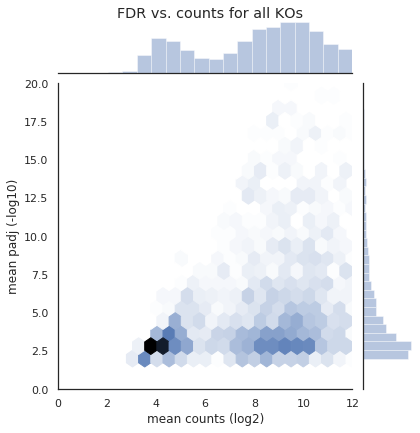

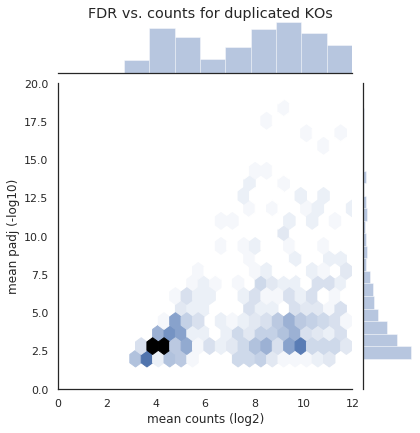

In [45]:
def plot_counts_vs_padj( df, thresh ):
    # remove non-DE genes
    dfE = df[['F.E', 'M.E', 'padj E']]
    dfE = dfE[ dfE['padj E'] <= thresh ]
    dfS = df[['F.S', 'M.S', 'padj S']]
    dfS = dfS[ dfS['padj S'] <= thresh ]

    # make the mean of counts and padj, without taking into account non-DE genes
    df = pd.concat([dfE, dfS], sort=False, axis=1)
    df['counts'] = np.log2( df[['F.E', 'F.S', 'M.E', 'M.S']].mean(axis=1) )
    df['padj'] = -np.log10( df[['padj E', 'padj S']].mean(axis=1) )

    # remove values we do not want to plot
    df = df[ ( df['counts'] < 12 ) & ( df['padj'] < 20 ) ]
    
    # plot
    sns.jointplot( data = df, x='counts', y='padj', kind='hexbin',
                   gridsize=20, xlim=(0,12), ylim=(0,20), mincnt=1
                 ).set_axis_labels('mean counts (log2)', 'mean padj (-log10)')
    return df

# distribution of genes related to all KOs

plot_counts_vs_padj( synthesis.copy(),
                     padj_thresh )
plt.suptitle( 'FDR vs. counts for all KOs', y=1 )
plt.savefig('../figures/distribution_mean_counts_vs_mean_padj-ALL_KO.png', dpi=300, bbox_inches='tight')
plt.show()

# distribution of genes related to duplicated KOs

plot_counts_vs_padj( synthesis[ synthesis['Consensus KEGG KO'].duplicated() ].copy(),
                     padj_thresh )
plt.suptitle( 'FDR vs. counts for duplicated KOs', y=1 )
plt.savefig('../figures/distribution_mean_counts_vs_mean_padj-DUPLICATED_KO.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
def drop_low_degs(gene, padj, count):
    """remove LFC related to low-count conditions or high p-value"""
    if gene['padj E'] > padj or gene[['F.E', 'M.E']].mean() < count:
        gene['LFC E'] = np.nan
    if gene['padj S'] > padj or gene[['F.S', 'M.S']].mean() < count:
        gene['LFC S'] = np.nan
    return gene

def color_ko( ko, f, N, res ):
        # get number of LFCs for each gene according to their sign (+, - or 0)
        posE, posS = np.sum( (res['LFC E'] > 0).values ), np.sum( (res['LFC S'] > 0).values )
        negE, negS = np.sum( (res['LFC E'] < 0).values ), np.sum( (res['LFC S'] < 0).values )
        stabE, stabS = np.sum( (res['LFC E'].isna()).values ), np.sum( (res['LFC S'].isna()).values )
        # separate KOs according to the type of their related DEGs and color them
        id = ko.split(': ')[0]
        if stabE == N and posS + stabS == N: # 0 -> +
            print( id + ' grey,red' , file=f )
        elif stabE == N and negS + stabS == N: # 0 -> -
            print( id + ' grey,blue' , file=f )
        elif posE + stabE == N and stabS == N: # + -> 0
            print( id + ' red,grey' , file=f )
        elif negE + stabE == N and stabS == N: # - -> 0
            print( id + ' blue,grey' , file=f )
        elif posE + stabE == N and posS + stabS == N: # + -> +
            print( id + ' red,black' , file=f )
        elif negE + stabE == N and negS + stabS == N: # - -> -
            print( id + ' blue,black' , file=f )
        elif posE + stabE == N and negS + stabS == N: # + -> -
            print( id + ' red,blue' , file=f )
        elif negE + stabE == N and posS + stabS == N: # - -> +
            print( id + ' blue,red' , file=f )
        else: # ambiguous = neg and positive values at the same day
            return False
        return True
    
def printer(file, synthesis, padj_thresh, count_thresh):
    """make the input file for kegg mapper and return the best DEG for each KO"""
    failed_ko = [] # KOs which were not displayed because none of their genes had LFC with enough significance
    ambiguous_ko = [] # KOs assigned to different genes with conflicting differential expression
    resolved_ambig = [] # KOs whose the conflict was resolved by taking the highest blast e-value

    with open(file, 'w') as f:
        for ko in synthesis['Consensus KEGG KO'].unique():
            # get genes linked to the KO
            subset_synthesis = synthesis[ synthesis['Consensus KEGG KO'] == ko ].copy()
            # drop LFC with high p-values
            res = subset_synthesis.apply( drop_low_degs, axis=1, args=(padj_thresh, count_thresh,) )
            res = res.dropna( subset=['LFC E', 'LFC S'], how='all' )
            N = len(res)
            # color the KO
            if N > 0: colored = color_ko( ko, f, N, res )
            else: failed_ko.append(ko)
            # if it is ambiguous
            if N > 0 and not colored:
                ambiguous_ko.append( synthesis.loc[res.index].copy() )
                # take the gene with the lowest blast e-value; replace the absence of e-value by 1
                best_align = synthesis.loc[ res[[ 'Mean BlastX e-value', 'Mean BlastP e-value'
                                                ]].replace('', 1).mean(axis=1).idxmin() ]
                best_align = pd.DataFrame( best_align ).T
                N = len(best_align)
                # color the KO
                colored = color_ko( ko, f, N, best_align )
                # if it is resolved
                if colored: resolved_ambig.append( best_align )
                # if not (cannot happen)
                else: print( ko + ' yellow' , file=f )

    ambiguous_ko = pd.concat( ambiguous_ko ).sort_values(by='Consensus KEGG KO')
    resolved_ambig = pd.concat( resolved_ambig ).sort_values(by='Consensus KEGG KO')

    print( 'number of failed KOs:', len(failed_ko) )
    print( 'number of unique ambiguous KOs:', len( ambiguous_ko['Consensus KEGG KO'].unique() ) )
    print( 'number of genes concerned by ambiguity:', len( ambiguous_ko ) )
    print( 'number of resolved KOs:', len( resolved_ambig['Consensus KEGG KO'].unique() ) )
    print( 'number of genes concerned by:', len( resolved_ambig ) )
    
    return failed_ko, ambiguous_ko, resolved_ambig

#### Test without filter

In [25]:
_, ambiguous_ko, _ = printer(
    '../data/annotation/kegg_mapper/kegg_mapper_input.NO_FILTER.txt',
    synthesis,
    padj_thresh,
    0
);

number of failed KOs: 0
number of unique ambiguous KOs: 138
number of genes concerned by ambiguity: 447
number of resolved KOs: 138
number of genes concerned by: 138


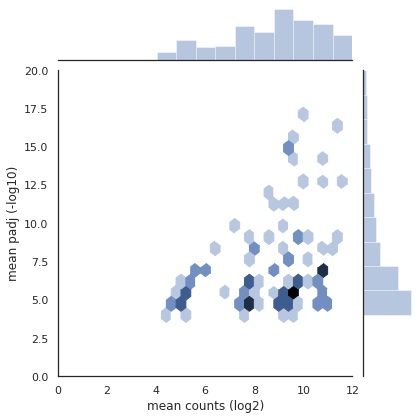

In [26]:
# distribution of genes related to ambiguous KOs

plot_counts_vs_padj( synthesis.loc[ ambiguous_ko.index ].copy(),
                     padj_low_thresh )
plt.suptitle( 'FDR vs. counts for ambiguous KOs', y=1 )
plt.savefig('../figures/distribution_mean_counts_vs_mean_padj-AMBIGUOUS_KO.png', dpi=300, bbox_inches='tight')
plt.show()

#### Print with filter
LFCs related to count below a cutoff are considerer as not differentially expressed

In [27]:
failed_ko, ambiguous_ko, resolved_ambig = printer(
    '../data/annotation/kegg_mapper/kegg_mapper_input.txt',
    synthesis,
    padj_low_thresh,
    0
)

number of failed KOs: 545
number of unique ambiguous KOs: 59
number of genes concerned by ambiguity: 198
number of resolved KOs: 59
number of genes concerned by: 59


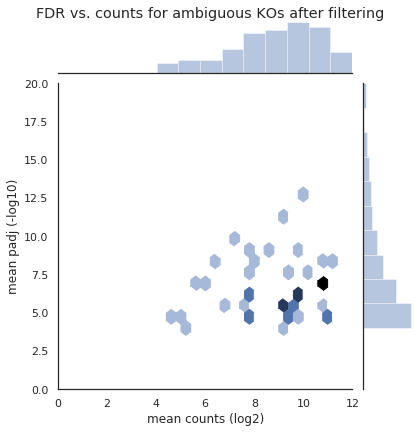

In [46]:
# distribution of genes related to duplicated KOs

plot_counts_vs_padj( synthesis.loc[ ambiguous_ko.index ].copy(),
                     padj_low_thresh )
plt.suptitle( 'FDR vs. counts for ambiguous KOs after filtering', y=1 )
plt.savefig('../figures/distribution_mean_counts_vs_mean_padj-FILTERED_AMBIGUOUS_KO.png', dpi=300, bbox_inches='tight')
plt.show()

### KEGG data file

In [29]:
ko_file = synthesis.copy()
print( 'number of genes :', len(ko_file) )
print( 'number of KOs:', len(ko_file['Consensus KEGG KO'].unique()) )

# remove failed KOs

ko_file = ko_file[ ~ko_file['Consensus KEGG KO'].isin( failed_ko ) ]
print( 'number of genes after removing failed KOs:', len(ko_file) )
print( 'number of unique KO after removing failed KOs:', len(ko_file['Consensus KEGG KO'].unique()) )

# replace genes with ambiguous KOs resolved at the previous step

ko_file = ko_file[ ~ko_file['Consensus KEGG KO'].isin( resolved_ambig['Consensus KEGG KO'].to_list() ) ]

print( 'number of genes after removing all genes related to resolved KOs:', len(ko_file) )
print( 'number of unique KO after removing all genes related to resolved KOs:', len(ko_file['Consensus KEGG KO'].unique()) )

ko_file = pd.concat([ ko_file.reset_index().rename({'index': 'Gene ID'}, axis=1),
                     resolved_ambig.reset_index().rename({'index': 'Gene ID'}, axis=1) ],
                    sort=False)

print( 'number of genes after adding resolved KOs:', len(ko_file) )
print( 'number of unique KO after adding resolved KOs:', len(ko_file['Consensus KEGG KO'].unique()) )

duplicated_kos = ko_file['Consensus KEGG KO'][ ko_file['Consensus KEGG KO'].duplicated() ]

print( '\nunique KOs related to different genes:', len(duplicated_kos.unique()), '-', len(duplicated_kos), 'genes' )

# prepare subset

ko_file = ko_file.drop([
    'Mean BlastX e-value', 'Mean BlastP e-value', 'Variation of LFC', 'Interaction term LFC',
    'Strength of variation', 'Mean BlastP e-value'], axis=1)
ko_file['KO'] = ko_file['Consensus KEGG KO'].apply( lambda x: x.split(': ')[0] )
ko_file = ko_file.reset_index(drop=True)

# merge with KO data

ko_file_pathway = pd.merge( ko_file, ko_pathways, how='left', left_on='KO', right_on='KO' )
ko_file_brite = pd.merge( ko_file, ko_brite, how='left', left_on='KO', right_on='KO' )

# clean

ko_file_pathway = ko_file_pathway[ ~ko_file_pathway['Pathway'].isnull() ]
ko_file_pathway = ko_file_pathway.drop('KO', axis=1).set_index('Gene ID')

ko_file_brite = ko_file_brite[ ~ko_file_brite['BRITE family'].isnull() ]
ko_file_brite = ko_file_brite.drop('KO', axis=1).set_index('Gene ID')

number of genes : 2920
number of KOs: 2050
number of genes after removing failed KOs: 2319
number of unique KO after removing failed KOs: 1505
number of genes after removing all genes related to resolved KOs: 2090
number of unique KO after removing all genes related to resolved KOs: 1446
number of genes after adding resolved KOs: 2149
number of unique KO after adding resolved KOs: 1505

unique KOs related to different genes: 448 - 644 genes


In [30]:
pd.to_pickle( ko_file, '../data/temp/kegg_ko_file.pkl' )
pd.to_pickle( ko_file_pathway, '../data/temp/kegg_ko_pathway.pkl' )
pd.to_pickle( ko_file_brite, '../data/temp/kegg_ko_brite.pkl' )

## Export fasta sequences of "final" transcripts
The "final" transcripts are the transcripts which were aggregated per genes and used indirectly through their consensus KO in the pathway analysis. They represent the subset of the assembled transcripts used in the final steps of the worklow, after all the previous filtering and aggregation steps.

In [31]:
# get genes and then transcripts related to the KOs we are using in the downstream steps

final_genes = pd.read_pickle( '../data/temp/kegg_ko_file.pkl' )['Gene ID']
final_transcripts = orthologous_trinotate[ orthologous_trinotate['#gene_id'].isin(final_genes) ]['transcript_id']
final_transcripts = [ transcript for gene in final_transcripts.str.split('; ').values for transcript in gene ]
print( 'number of final transcripts:', len(final_transcripts) )

number of final transcripts: 10263


In [33]:
# get number of sequences in the file

N = 0
with open( '../data/degs_to_annotate.fasta', 'r' ) as f:
    for line in f.readlines():
        if line.startswith('>'): N += 1

```python            
# get sequences of final transcripts

fasta_degs = ''
cnt = 0
with open( '../data/degs_to_annotate.fasta', 'r' ) as f:
    seq = False
    for k, line in enumerate( f.readlines() ):
        # get transcript header
        if line.startswith('>') and line[1:].split(' ')[0] in final_transcripts:
            fasta_degs += line
            seq = True
        # get transcript sequence
        elif seq:
            fasta_degs += line
            seq = False
        # progress bar
        cnt = progress(cnt, k/2, N)
        
# save the subset

with open('../data/final_used_genes.fasta', 'w') as f: f.write( fasta_degs )
```

In [34]:
x = 0
with open( '../data/final_used_genes.fasta', 'r' ) as f:
    for line in f.readlines():
        if line.startswith('>'): x += 1

print('initial number of transcripts:', N)
print('number of DEGs:', len(final_genes))
print('number of transcripts in the subset:', x)

initial number of transcripts: 39469
number of DEGs: 2149
number of transcripts in the subset: 10263


## E-value distribution of final transcripts

In [35]:
def remove_zeros( evals, blast, subset ):
    evals = evals.astype(float)
    m = evals[ evals != 0 ].min()
    df_evals = pd.DataFrame( evals.replace( 0, m ).apply( np.log10 ) )
    df_evals[ 'Blast' ] = blast
    df_evals[ 'Subset' ] = subset
    df_evals = df_evals.rename( { evals.name: 'E-value' }, axis=1 )
    return df_evals

# get all data before aggregations of final transcripts

final_trinotate = blasted[ blasted['transcript_id'].isin(final_transcripts) ]
blastp_evalues = final_trinotate['BlastP E-value'].dropna()
blastx_evalues = final_trinotate[['transcript_id', 'BlastX E-value']].drop_duplicates()['BlastX E-value'].dropna()
print( 'number of BlastX e-values for final transcripts:', len(blastx_evalues) )
print( 'number of BlastP e-values for final transcripts:', len(blastp_evalues) )

# convert values

final_blastp_evalues = remove_zeros( blastp_evalues, 'P', 'Final' )
final_blastx_evalues = remove_zeros( blastx_evalues, 'X', 'Final' )

# same for all transcripts

blastp_evalues = blasted['BlastP E-value'].dropna()
blastx_evalues = blasted[['transcript_id', 'BlastX E-value']].drop_duplicates()['BlastX E-value'].dropna()
print( 'number of BlastX e-values for all transcripts:', len(blastx_evalues) )
print( 'number of BlastP e-values for all transcripts:', len(blastp_evalues) )
    
all_blastp_evalues = remove_zeros( blastp_evalues, 'P', 'All' )
all_blastx_evalues = remove_zeros( blastx_evalues, 'X', 'All' )
evalues = pd.concat( [ final_blastp_evalues, final_blastx_evalues, all_blastp_evalues, all_blastx_evalues ]).reset_index(drop=True)

number of BlastX e-values for final transcripts: 9987
number of BlastP e-values for final transcripts: 16155
number of BlastX e-values for all transcripts: 19509
number of BlastP e-values for all transcripts: 30503


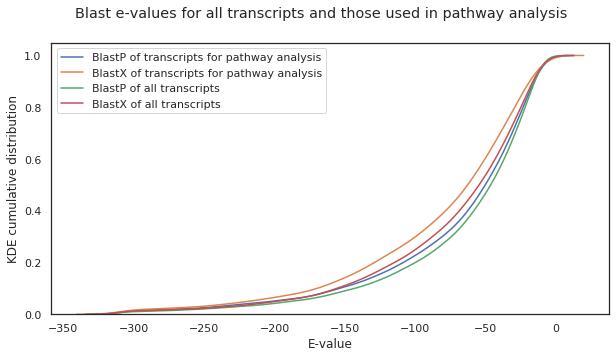

In [37]:
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(final_blastp_evalues['E-value'], label='BlastP of transcripts for pathway analysis', cumulative=True)
sns.kdeplot(final_blastx_evalues['E-value'],  label='BlastX of transcripts for pathway analysis', cumulative=True)
sns.kdeplot(all_blastp_evalues['E-value'], label='BlastP of all transcripts', cumulative=True)
sns.kdeplot(all_blastx_evalues['E-value'], label='BlastX of all transcripts', cumulative=True)
plt.suptitle('Blast e-values for all transcripts and those used in pathway analysis')
plt.xlabel('E-value')
plt.ylabel('KDE cumulative distribution')
plt.savefig( '../figures/distribution_evalues_final_transcripts.png', dpi=300 )

## Statistics

In [38]:
e_padj = ko_file[ko_file['padj E'] <= padj_thresh].index
e_count = ko_file[ko_file[['F.E', 'M.E']].mean(axis=1) >= count_thresh].index
e = ko_file.loc[ set(e_padj) & set(e_count), 'LFC E' ].astype(float)

s_padj = ko_file[ko_file['padj S'] <= padj_thresh].index
s_count = ko_file[ko_file[['F.S', 'M.S']].mean(axis=1) >= count_thresh].index
s = ko_file.loc[ set(s_padj) & set(s_count), 'LFC S' ].astype(float)

# separate by the sign of the LFC
a = pd.DataFrame(e[e<0].to_list())
b = pd.DataFrame(e[e>0].to_list())
c = pd.DataFrame(s[s<0].to_list())
d = pd.DataFrame(s[s>0].to_list())

# display the stats
stats = pd.concat([a,b,c,d], axis=1).describe()
stats.columns = ['down E', 'up E', 'down S', 'up S']
stats

,down E,up E,down S,up S
count,731.000000,450.000000,1198.000000,207.000000
mean,-2.650503,1.810783,-2.867700,1.913338
std,3.174755,1.666796,3.499284,1.614516
min,-24.900813,0.376661,-25.569566,0.448365
25%,-2.593568,1.021722,-2.549313,1.057470
50%,-1.408812,1.379552,-1.435935,1.508261
75%,-0.907400,2.068643,-0.990619,2.180776
max,-0.384359,22.868146,-0.313368,15.010252


In [39]:
# statistics for absolute values
pd.concat([abs(e).describe(percentiles=[.05,.15,.25,.50,.75]), abs(s).describe(percentiles=[.05,.15,.25,.50,.75])], axis=1)

,LFC E,LFC S
count,1181.000000,1405.000000
mean,2.330542,2.727093
std,2.731104,3.307053
min,0.376661,0.313368
5%,0.588290,0.593084
15%,0.779315,0.818161
25%,0.947783,0.999287
50%,1.393948,1.450317
75%,2.354655,2.482050
max,24.900813,25.569566


## Export

In [ ]:
# color the dataframes
def style_lfcs(data):
    # normalize from 0 to 1, with a LFC of 0 normalized at 0.5
    n, p = data[data <= 0], data[data > 0]
    n = 0.5 * ( n - n.min().min() ) / -n.min().min()
    p = 0.5 * ( 1 + p / p.max().max() )
    # create colormap from the palette 'coolwarm'
    cmap = ListedColormap(sns.color_palette('coolwarm', 264))
    # convert values to colors and set css style
    style = pd.DataFrame('', columns=data.columns, index=data.index)
    for c in data:
        n_vals = n[c].dropna()
        p_vals = p[c].dropna()
        for g, v in n_vals.items():
            color = matplotlib.colors.rgb2hex( cmap(v) )
            style.loc[g, c] = f'background-color: {color}'
        for g, v in p_vals.items():
            color = matplotlib.colors.rgb2hex( cmap(v) )
            style.loc[g, c] = f'background-color: {color}'
    return style

def style_padj(data):
    try: data = data.replace({np.nan: 1., '': 1.})
    except: pass
    # set colormap
    cmap = sns.light_palette( "green", as_cmap=True )
    hls = sns.hls_palette( l=.85 )
    # convert to log scale
    min = -np.log10( data[ data > 0 ].min().min() )
    data = data.applymap( lambda elmt: -np.log10(elmt) if elmt > 0 and elmt <= padj_thresh else 0 if elmt > 0 else min )
    # normalize from 0 to 1
    M, m = data.max().max(), data.min().min()
    data = (data - m) / (M - m)
    # convert values to colors and set css styke
    data = data.applymap( lambda elmt:
                         matplotlib.colors.rgb2hex( cmap(elmt) ) if not np.isnan(elmt) and elmt > 0
                         else matplotlib.colors.rgb2hex( hls[0] ) if not np.isnan(elmt)
                         else elmt )
    data = data.applymap( lambda elmt: f'background-color: {elmt};' if isinstance(elmt, str) else '' )
    return data

def style_counts(data):
    # set colormap
    cmap = sns.cubehelix_palette(as_cmap=True)
    # convert to log scale
    data=data.astype(float)
    data = data.apply(lambda elmt: np.log2(elmt+0.1))
    # normalize from 0 to 1
    data = (data - 0) / (data.max().max() - 0)
    # convert values to colors and set css styke
    data = data.applymap( lambda elmt: matplotlib.colors.rgb2hex( cmap(elmt) ) if not np.isnan(elmt) else elmt )
    data = data.applymap( lambda elmt: f'background-color: {elmt}; color: white' if isinstance(elmt, str) else '' )
    return data
    
def styling_synthesis(data):
    """execute styling"""
    counts = style_counts(data.iloc[:, :4])
    lfc1 = style_lfcs(data.iloc[:, 4:5])
    padj1 = style_padj(data.iloc[:, 5:6])
    lfc2 = style_lfcs(data.iloc[:, 6:7])
    padj2 = style_padj(data.iloc[:, 7:8])
    var = pd.DataFrame('',columns=data.iloc[:,8:9].columns, index=data.iloc[:,8:9].index)
    inter = style_lfcs(data.iloc[:, 9:10])
    padj3 = style_padj(data.iloc[:, 10:11])
    other = pd.DataFrame('',columns=data.iloc[:,11:].columns, index=data.iloc[:,11:].index)
    return pd.concat([counts, lfc1, padj1, lfc2, padj2, var, inter, padj3, other], axis=1)

def styling_kegg(data):
    """execute styling"""
    other1 = pd.DataFrame('',columns=data.iloc[:,:1].columns, index=data.iloc[:,:1].index)
    counts = style_counts(data.iloc[:, 1:5])
    lfc1 = style_lfcs(data.iloc[:, 5:6])
    padj1 = style_padj(data.iloc[:, 6:7])
    lfc2 = style_lfcs(data.iloc[:, 7:8])
    padj2 = style_padj(data.iloc[:, 8:9])
    padj3 = style_padj(data.iloc[:, 9:10])
    other2 = pd.DataFrame('',columns=data.iloc[:,10:].columns, index=data.iloc[:,10:].index)
    return pd.concat([other1, counts, lfc1, padj1, lfc2, padj2, padj3, other2], axis=1)

In [ ]:
with pd.ExcelWriter('../data/annotation/trinotate_raw_data.xlsx') as writer:
    trinotate.to_excel(writer, 'Trinotate report')
    blasted_ko.to_excel(writer, 'Aligned transcripts')
    corrob_kos.to_excel(writer, 'Consensus KOs')
    orthologous_trinotate.to_excel(writer, 'Aggregated genes by KOs')

In [ ]:
with pd.ExcelWriter('../data/annotation/ambiguous_ko.xlsx') as writer:
    ambiguous_ko.to_excel(writer, 'Ambiguous KO')
    resolved_ambig.to_excel(writer, 'Resolved KO')

In [ ]:
with pd.ExcelWriter('../data/annotation/synthesis.xlsx') as writer:
    synthesis.style.apply( styling_synthesis, axis=None ).to_excel(writer, 'Synthesis')
    ko_file_pathway.reset_index().style.apply( styling_kegg, axis=None ).to_excel(writer, 'KEGG Pathway')
    ko_file_brite.reset_index().style.apply( styling_kegg, axis=None ).to_excel(writer, 'KEGG BRITE')